In [12]:
# Made by Daniel Crawford
# Student Net ID: dsc160130
# Course: CS6364 - Artificial Intelligence

import torch
import torch.nn as nn
import numpy as np
import cv2
import os
import urllib
import gzip
import time

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm import tqdm

# Torch setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train hyperparameters
num_epochs = 25
learning_rate = 0.001


# Data hyperparameters
batch_size = 64

# Data details

train_size = 60000
test_size = 10000
data_rows = 28
data_cols = 28
data_classes = 10

# Data
test_data_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz'
test_data_file = 'test_data.gz'
test_labels_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz'
test_labels_file = 'test_labels.gz'
train_data_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz'
train_data_file = 'train_data.gz'
train_labels_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz'
train_labels_file = 'train_labels.gz'


if not os.path.exists(train_data_file):
    urllib.request.urlretrieve(train_data_url, train_data_file)
if not os.path.exists(train_labels_file):
    urllib.request.urlretrieve(train_labels_url, train_labels_file)
if not os.path.exists(test_data_file):
    urllib.request.urlretrieve(test_data_url, test_data_file)
if not os.path.exists(test_labels_file):
    urllib.request.urlretrieve(test_labels_url, test_labels_file)

In [13]:
file_train_data = gzip.GzipFile(train_data_file, 'r')
file_train_data.read(16)
buffer_train_data = file_train_data.read(train_size * data_rows * data_cols)
train_data = np.frombuffer(buffer_train_data, dtype=np.uint8).astype(np.int32)
train_data = train_data.reshape(train_size, 1, data_rows, data_cols)

file_train_labels = gzip.open(train_labels_file, 'r')
file_train_labels.read(8)
buffer_train_labels = file_train_labels.read(train_size)
train_labels = np.frombuffer(buffer_train_labels, dtype=np.uint8).astype(np.int32)

file_test_data = gzip.open(test_data_file, 'r')
file_test_data.read(16)
buffer_test_data = file_test_data.read(test_size * data_rows * data_cols)
test_data = np.frombuffer(buffer_test_data, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(test_size, 1, data_rows, data_cols)

file_test_labels = gzip.open(test_labels_file, 'r')
file_test_labels.read(8)
buffer_test_labels = file_test_labels.read(test_size)
test_labels = np.frombuffer(buffer_test_labels, dtype=np.uint8).astype(np.int32)

In [14]:
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)
test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

train = torch.utils.data.TensorDataset(train_data, train_labels)
test = torch.utils.data.TensorDataset(test_data, test_labels)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)

In [15]:
class Q1Model(nn.Module):
    def __init__(self, data_num_channels, data_width, data_height, kernel_type):
        kernel = None
        if kernel_type == 'vertical':
            kernel = torch.Tensor([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
        if kernel_type == 'horizontal':
            kernel = torch.Tensor([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

        super(Q1Model, self).__init__()
        self.conv = nn.Conv2d(data_num_channels, data_num_channels, kernel_size=(3, 3), padding=1, stride=1,
                               bias=False)
        self.conv.weight.data[:, :, ] = kernel
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1)
        self.vectorizer = nn.Flatten()
        self.fc = nn.Linear(data_width * data_height * data_num_channels, 100)

    def forward(self, x):
        x = x.reshape(1, 1, *x.shape)
        altered_images = []
        y = x

        y = self.conv(y)
        altered_images.append(y[0][0])
        y = self.relu(y)
        altered_images.append(y[0][0])
        y = self.maxpool(y)
        altered_images.append(y[0][0])

        return self.fc(self.vectorizer(y)), altered_images

class Q2Model(nn.Module):
    def __init__(self, data_classes):
        super(Q2Model, self).__init__()

        self.cnn_layers = nn.ModuleList([
            nn.Conv2d(1, 4, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4,4, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ])

        self.linear_layers = nn.ModuleList([
            nn.Flatten(),
            nn.Linear(4 * 7 * 7, data_classes),
            nn.Softmax(dim=1)
        ])

    def forward(self, x):
        y = x

        for layer in self.cnn_layers:
            y = layer(y)

        for layer in self.linear_layers:
            y = layer(y)
        return y
    
class Q3Model(nn.Module):

In [16]:
def train_model(model, optimizer, criterion, device, train_loader, test_loader, num_epochs):
    model = model.to(device)
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        train_loss = 0
        n = 0
        tq = tqdm(train_loader)
        tq.set_description('Epoch {0:d}, Average Train Loss: {1:5.6f}'.format(epoch, 0))
        model.train()
        for i, data in enumerate(tq):
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)

            outputs = model(batch)
            optimizer.zero_grad()
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(batch)
            n += len(batch)
            tq.set_description('Epoch {0:d}, Average Train Loss: {1:5.6f}'.format(epoch,train_loss / n,))
        train_losses.append(train_loss / n)

        test_loss = 0
        test_len = 0
        test_correct = 0
        model.eval()
        for batch, labels in test_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels.long())
            test_loss += loss.item() * len(batch)
            _, predicted = torch.max(outputs.data, 1)
            test_len += len(labels)
            test_correct += (predicted == labels).sum().item()
        print('Test Accuracy: {0:3.2f}, Test Average Loss: {1:5.6f}'.format(test_correct / test_len * 100, test_loss / test_len))
        time.sleep(0.1)
        test_losses.append(test_loss / n)
    return train_losses, test_losses

def q1():
    img = cv2.imread('Q1.jpg', cv2.IMREAD_GRAYSCALE)
    img = torch.Tensor(img)
    vert_model = Q1Model(1, img.shape[0], img.shape[1], 'vertical')
    _, images = vert_model(img)
    for image in images:
        image = image.detach().numpy()
        imshow(image, cmap='gray')
        plt.show()
    hori_model = Q1Model(1, img.shape[0], img.shape[1], 'horizontal')
    _, images = hori_model(img)
    for image in images:
        image = image.detach().numpy()
        imshow(image, cmap='gray')
        plt.show()

def q2():
    model = Q2Model(data_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    train_model(model, optimizer, criterion, device, train_loader, test_loader, num_epochs)


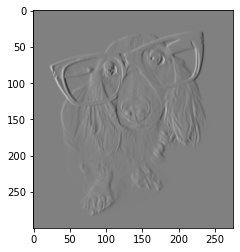

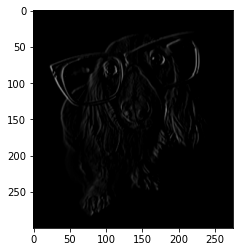

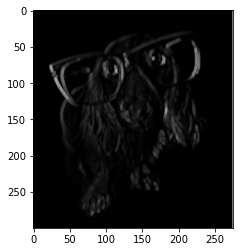

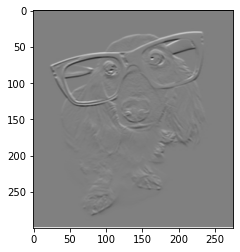

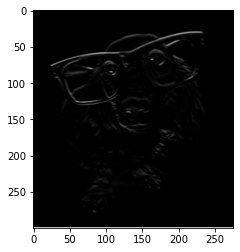

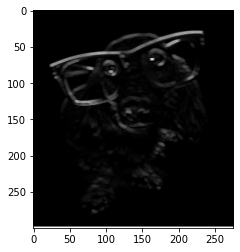

In [17]:
q1()

In [18]:
q2()

Epoch 24, Average Train Loss: 1.567483: 100%|██████████| 938/938 [00:05<00:00, 178.13it/s]


Test Accuracy: 0.83, Test Average Loss: 1.645501
Test Accuracy: 0.85, Test Average Loss: 1.619661
Test Accuracy: 0.86, Test Average Loss: 1.610979
Test Accuracy: 0.86, Test Average Loss: 1.606710
Test Accuracy: 0.86, Test Average Loss: 1.603835
Test Accuracy: 0.86, Test Average Loss: 1.600826
Test Accuracy: 0.87, Test Average Loss: 1.597412
Test Accuracy: 0.87, Test Average Loss: 1.595350
Test Accuracy: 0.87, Test Average Loss: 1.594664
Test Accuracy: 0.87, Test Average Loss: 1.593162
Test Accuracy: 0.87, Test Average Loss: 1.592570
Test Accuracy: 0.87, Test Average Loss: 1.591008
Test Accuracy: 0.87, Test Average Loss: 1.590870
Test Accuracy: 0.87, Test Average Loss: 1.589707
Test Accuracy: 0.87, Test Average Loss: 1.589457
Test Accuracy: 0.87, Test Average Loss: 1.589781
Test Accuracy: 0.87, Test Average Loss: 1.589229
Test Accuracy: 0.87, Test Average Loss: 1.589111
Test Accuracy: 0.88, Test Average Loss: 1.588305
Test Accuracy: 0.87, Test Average Loss: 1.588498
Test Accuracy: 0.87,